<a href="https://colab.research.google.com/github/soladobola/FFT-fixedPoint/blob/master/JupiterFFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fixed-point FFT**


Na samom početku importovacemo neophodne bibiloteke.


In [1]:
from FixedPoint import FXfamily
from ComplexFP import *
from RoundingUtility import *
import matplotlib.pyplot as plt
import numpy as np

Za pocetak cemo isprobati komercijalnu funkciju za rad u pokretnom zarezu. To je **np.fft.fft**, pogledajmo rezultat za konkretne vrednosti u vremenskom domenu.

In [2]:
sample_t = [1, 2, 3, 4, 5, 6, 7, 8]
np.fft.fft(sample_t)

array([36.+0.j        , -4.+9.65685425j, -4.+4.j        , -4.+1.65685425j,
       -4.+0.j        , -4.-1.65685425j, -4.-4.j        , -4.-9.65685425j])

Kao sto vidimo, za uneti niz diskretnih vrednosti dobili sto isto toliko elemenata kao rezultat koji nam predstavlja magnitudu odredjenih učestanosti. Učestanost u ovom smislu je neodredjena jer ne znamo frekvenciju kojom je uzorak uzet, medjutim ako znamo osnovnu učestanost **w0** onda su redom koeficijenti **w0, 2w0, 3w0** itd, osim nulte tačke koja nam predstavlja srednju vrednost.


Međutim, ova funkcija radi u pokretnom zarezu, naš cilj jeste realizacije ove funkcionalnosti ali u fiksnom zarezu. Pogledajmo primer rada naše funkcije za ovaj konkretan slučaj.

In [3]:
sample_t = [1, 2, 3, 4, 5, 6, 7, 8]

# Initialize resolution
int_bits = 8
fraction_bits = 6

# Initialize family
fam = FXfamily(fraction_bits, int_bits)

complex_sample_t = realInComplex(sample_t, fam)
toNumpyArray(fft(complex_sample_t, fam))

array([36.    +0.j    , -3.9375+9.6875j, -4.    +3.9375j, -3.75  +1.25j  ,
       -4.    +0.j    , -4.0625-1.6875j, -4.    -3.9375j, -4.25  -9.25j  ])

Kao što primecujemo, malo je komplikovanije, ali smo dobili slični rezultat. Na početku smo morali da izaberemo rezoluciju i pridruziti je samoj fft funkciji. Da ne bi stalno pisali ovo uvodimo novu funkciju koja ce se zvati **fixedfft** koja ce zapravo ove korake raditi umesto nas. Pogledajmo primer.

In [4]:
#def fixedfft(fraction_bits, int_bits, arr, round=None)
sample_t = [1, 2, 3, 4, 5, 6, 7, 8]
fixedfft(8, 8, sample_t)

array([36.      +0.j      , -4.015625+9.578125j, -3.984375+3.984375j,
       -4.      +1.65625j , -4.      +0.j      , -3.984375-1.578125j,
       -4.015625-3.984375j, -4.      -9.65625j ])

Kao sto vidimo iz definicije **fixedfft** funkcije postoji jos jedan opcioni parametar pod nazivom **round**, on nam zapravo predstavlja naziv metode koju zelimo da upotrebimo za zaokrugljivanje medjurezultata operacija.
Implementirane metode su:
def trimBinary(opt): <br>
        'TRUNC' or 'ROUND_DOWN' <br>
        'ROUND_UP' <br>
        'ROUND_TOWARDS_ZERO' <br>
        'ROUND_AWAY_FROM_ZERO' <br>
        'ROUND_HALF_DOWN' <br>
        'ROUND_HALF_UP' <br>
        'ROUND_HALF_TOWARDS_ZERO' <br>
        'ROUND_HALF_AWAY_FROM_ZERO' <br>
        'ROUND_HALF_TO_EVEN' <br>
        'ROUND_HALF_TO_ODD' <br>
        'RANDOM_ROUND_UP' <br>
        <br>
        **U slučaju odsustva ovog parametra podrazumevana vrednost je 'TRUNC'**
        <br>
        <br>
 Pogledajmo primer nase funkcije sa jednom od ovih metoda.


In [5]:
sample_t = [1, 2, 3, 4, 5, 6, 7, 8]
fixedfft(3, 8, sample_t, 'ROUND_HALF_TOWARDS_ZERO')
#fixedfft(4, 8, sample_t, 'ROUND_AWAY_FROM_ZERO')
#fixedfft(5, 8, sample_t, 'ROUND_UP')

array([36.    +0.j   , -1.125 +7.75j , -2.5   +4.j   , -2.5   +3.125j,
       -4.    +0.j   , -4.875 +0.25j , -5.5   -4.j   , -7.5  -11.125j])

Savrseno, medjutim, sta ako zelimo da procenimo koliko odstupamo od **np.fft.ftt** funkcije?<br>
Pokusacemo to da uradimo na 2 nacina. <br> <br>
**I način**: iskorisimo matematiku! Ideja je jednostavna, napravimo funkciju koja ce nam dati **distancu** izmedju dva numpy niza. Distanca moze biti **MSE (mean square error)**. Racunacemo po formuli: **mse = sum(|y - yr|^2)/n**

In [6]:
def mse(arr1, arr2):
  assert len(arr1) == len(arr2)
  mag = []
  for x in range(len(arr1)):
    mag.append(abs(arr1[x] - arr2[x])**2)
  return sum(mag)/len(arr1)


Pogledajmo sada jedan jednostavan primer:

In [7]:
signal_t = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
A = np.fft.fft(signal_t)
B = fixedfft(4, 10, signal_t, 'ROUND_UP')
err = mse(A, B)
print("Mean square error is " + str(err))

Mean square error is 24.205499855729546


Sada se prirodno postavlja pitanje: "Koja je najbolja metoda?", hajde da vidimo!

In [8]:
methods = ['ROUND_DOWN', 'ROUND_UP', 'ROUND_TOWARDS_ZERO', 
           'ROUND_AWAY_FROM_ZERO', 'ROUND_HALF_DOWN', 'ROUND_HALF_UP', 
           'ROUND_HALF_TOWARDS_ZERO', 'ROUND_HALF_AWAY_FROM_ZERO', 
           'ROUND_HALF_TO_EVEN', 'ROUND_HALF_TO_ODD', 'RANDOM_ROUND_UP']

signal_t = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
y = np.fft.fft(signal_t)

indBest = 0;
mseBest = float('inf')
ind = 0
for x in methods:
  ycap = fixedfft(4, 10, signal_t, x)
  tempMse = mse(y, ycap)
  if tempMse < mseBest:
      mseBest = tempMse
      indBest = ind
  ind += 1
print("Best method is " + methods[indBest] + " with MSE = " + str(mseBest))


Best method is ROUND_DOWN with MSE = 6.271842080442643


Naravno treba napomenuti da je ovo slucaj za ove konkretne parametre, ne mora da znaci da je generalno tacno, ako promenimo recimo preciznost i rezultat moze da se razlikuje. <br> <br>

Pogledajmo sada kako MSE zavisi od broja bitova posle decimalnog zareza. Dakle metodu zaokrugljivanja cemo ovde fiksirati.


In [39]:
def mseiter(int_bits, min_frac_bits, max_frac_bits, sample, round):
  res = []
  ref = np.fft.fft(sample)
  for x in range(min_frac_bits, max_frac_bits + 1, 2):
    res.append(mse(ref, fixedfft(x, int_bits, sample, round)))
  return np.array(res)

In [26]:
mseiter(10, 2, 5, [1, 2, 3, 4, 5, 6, 7, 8], 'ROUND_DOWN')

array([30.60786438,  0.13730163,  0.25862197,  0.06101646])

Naravno, bolje ćemo steci intuiciju ako prikažemo ove podatke grafički. Mada cemo uzeti vise odabarika zbog efekta akomuliranja greske.

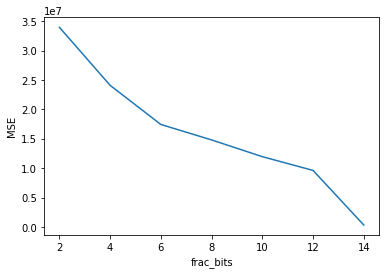

In [42]:
sample = range(1, 2**9 + 1)
min_frac_bits = 2
max_frac_bits = 15
plt.ylabel("MSE")
plt.xlabel("frac_bits")
data = mseiter(32, min_frac_bits, max_frac_bits, sample, 'RANDOM_ROUND_UP')
xvalues = range(min_frac_bits, max_frac_bits + 1, 2)
plt.plot(xvalues, data)
plt.show()

**Note:** oznaka **1e8** na y-osi nam kazuje da je vrednost funkcije zapravo skalirana sa **10^8**.
<br>

**II način**: Umesto da računamo gresku, zasto ne bismo samo iscrtali grafike jedan pored drugog? Hajde da probamo. Isrtacemo **power spektar** nase funkcije i np.fft.fft.

In [44]:
def drawfft(int_bits, n_bits, sample, round):
  ref = np.fft.fft(sample)
  ref = np.abs(ref)
  plt.plot(ref)
  # Common
  plt.ylabel("magnitude")
  plt.xlabel("frequency")
  legends = ['float_precision'] + round
  for x in round:
    data = np.abs(fixedfft(n_bits, int_bits, sample, x))
    plt.plot(data)
  # show plots
  plt.legend(legends)
  plt.show()


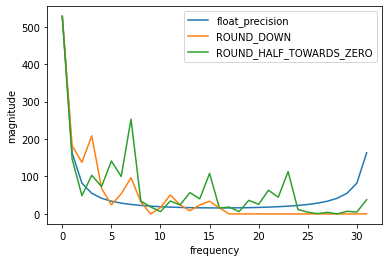

In [57]:
drawfft(16, 2, range(1, 2**5 + 1), ['ROUND_DOWN', 'ROUND_HALF_TOWARDS_ZERO'])

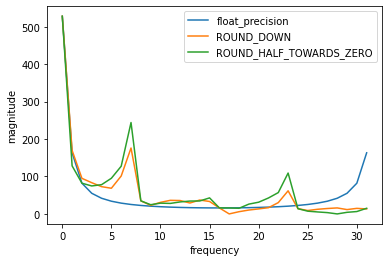

In [58]:
drawfft(16, 3, range(1, 2**5 + 1), ['ROUND_DOWN', 'ROUND_HALF_TOWARDS_ZERO'])

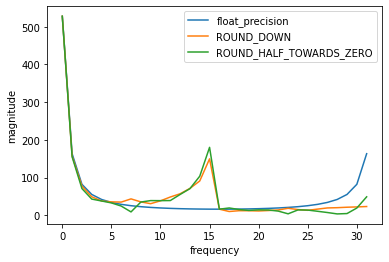

In [59]:
drawfft(16, 4, range(1, 2**5 + 1), ['ROUND_DOWN', 'ROUND_HALF_TOWARDS_ZERO'])

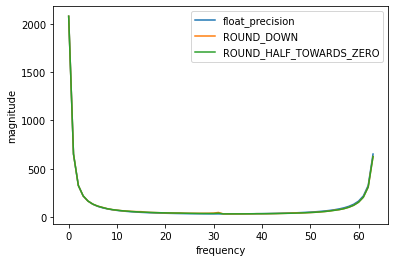

In [64]:
drawfft(16, 10, range(1, 2**6 + 1), ['ROUND_DOWN', 'ROUND_HALF_TOWARDS_ZERO'])